For a given day, plot in situ & satellite fields in the Beaufort Sea

In [11]:
import os
import s3fs
import requests
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from pprint import pprint
from pathlib import Path
import h5py

In [12]:
# define date and domain of interest
start_date = "2021-09-01T00:00:00"
end_date = "2021-09-01T23:59:59" # one day 
date_range = start_date + "/" + end_date

# beaufort
lonrange = [-160, -130]
latrange = [68, 80]
bounding_box = (f'{lonrange[0]},{latrange[0]},{lonrange[1]},{latrange[1]}') # make this a string

In [3]:
# create a local downloads folder
os.makedirs("downloads", exist_ok=True)


### L2 SMAP SSS

Also on-premesis. 

Use NRT product (C1972954180-PODAAC), as this notebook is intended to be used during a field campaign.
Delayed-time product is C1972961258-PODAAC


In [13]:
# concept_id = 'C1972954180-PODAAC' # from earthdatasearch 'C1972955240-PODAAC' is RSS smap
concept_id = 'C1972961258-PODAAC' # delayed mode https://search.earthdata.nasa.gov/search/granules?p=C1972961258-PODAAC
granule_url = 'https://cmr.earthdata.nasa.gov/search/granules'
response = requests.get(granule_url,
                       params={
                           'concept_id': concept_id,
                           'temporal': date_range,  
                           'bounding_box': bounding_box,
                           'page_size': 200,
                       },
                       headers={
                           'Accept': 'application/json'
                       }
                      )
print(response.headers['CMR-Hits']) 

10


In [14]:
# download the granules
# need this to authenticate with Drive
from requests.auth import HTTPBasicAuth


granules = response.json()['feed']['entry']
for granule in granules:
    #we need to find the 'drive' link for the datafile, assuming the first link[0] is drive is not always correct. sometimes it's opendap.
    for gl in granule['links']:
        print(gl)
        if '/drive/' in gl['href']:
            url = gl['href']
            break
    print(url)
    id = granule['title']
    # Password here is the 'Drive API Password' https://podaac-tools.jpl.nasa.gov/drive/
    # user here is the Earthdata Login username
    r = requests.get(url, auth=HTTPBasicAuth('user', 'password'))
    outfile = Path('downloads', id)
    #if not outfile.exists():
    print(url, id)
    with open(outfile, 'wb') as f:
        f.write(r.content)   

{'rel': 'http://esipfed.org/ns/fedsearch/1.1/data#', 'title': 'The OPENDAP location for the granule.', 'hreflang': 'en-US', 'href': 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/smap/L2/JPL/V5.0/2021/243/SMAP_L2B_SSS_35165_20210831T233808_R17030_V5.0.h5.html'}
{'rel': 'http://esipfed.org/ns/fedsearch/1.1/data#', 'title': 'The base directory location for the granule.', 'hreflang': 'en-US', 'href': 'https://podaac-tools.jpl.nasa.gov/drive/files/allData/smap/L2/JPL/V5.0/2021/243/SMAP_L2B_SSS_35165_20210831T233808_R17030_V5.0.h5'}
https://podaac-tools.jpl.nasa.gov/drive/files/allData/smap/L2/JPL/V5.0/2021/243/SMAP_L2B_SSS_35165_20210831T233808_R17030_V5.0.h5
https://podaac-tools.jpl.nasa.gov/drive/files/allData/smap/L2/JPL/V5.0/2021/243/SMAP_L2B_SSS_35165_20210831T233808_R17030_V5.0.h5 SMAP_L2B_SSS_35165_20210831T233808_R17030_V5.0.h5
{'rel': 'http://esipfed.org/ns/fedsearch/1.1/data#', 'title': 'The OPENDAP location for the granule.', 'hreflang': 'en-US', 'href': 'https://podaac-op

In [6]:
h5 = h5py.File(outfile, 'r')
h5.keys() # variable names

<KeysViewHDF5 ['anc_dir', 'anc_spd', 'anc_sss', 'anc_sst', 'anc_swh', 'antazi_aft', 'antazi_fore', 'azi_aft', 'azi_fore', 'ice_concentration', 'inc_aft', 'inc_fore', 'land_fraction_aft', 'land_fraction_fore', 'lat', 'lon', 'n_h_aft', 'n_h_fore', 'n_v_aft', 'n_v_fore', 'nedt_h_aft', 'nedt_h_fore', 'nedt_v_aft', 'nedt_v_fore', 'num_ambiguities', 'quality_flag', 'row_time', 'smap_ambiguity_dir', 'smap_ambiguity_spd', 'smap_high_dir', 'smap_high_dir_smooth', 'smap_high_spd', 'smap_spd', 'smap_sss', 'smap_sss_uncertainty', 'tb_h_aft', 'tb_h_bias_adj', 'tb_h_fore', 'tb_v_aft', 'tb_v_bias_adj', 'tb_v_fore']>

In [ ]:
# Load h5 file
variable_names = [
    '/lat',  # length 720
    '/lon',  # length 1440
    '/time', # length 1 
    '/sss_smap' # length 720
    ]

with h5py.File(outfile, 'r') as h5:
    data_vars = {}
    for varname in variable_names:
        var = h5[varname]
        name = varname.split('/')[-1]
        # Convert attributes
        attrs = {}
        for k, v in var.attrs.items():
            if k != 'DIMENSION_LIST':
                if isinstance(v, bytes):
                    attrs[k] = v.decode('utf-8')
                else:
                    attrs[k] = v
        data = var[:]
        if '_FillValue' in attrs:
            data = np.where(data < attrs['_FillValue'], data, np.nan)
        # data_vars[name] = (['segment'], data, attrs) # skip adding attrs for now
        data_vars[name] = (['segment'], data)
    smap_l2 = xr.Dataset(data_vars)
smap_l2


ValueError: Could not convert tuple of form (dims, data[, attrs, encoding]): (['segment'], array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)) to Variable.

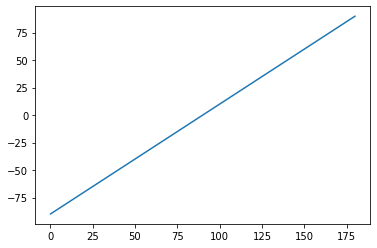

### MODIS SST - from Bia's code, shared/Project1/villasboas_MODIS_SST.ipynb

In [ ]:
provider = 'POCLOUD'
url = 'https://cmr.earthdata.nasa.gov/search/collections.umm_json'
response = requests.get(url,
                        params={
                            'cloud_hosted': 'True',
                            'has_granules': 'True',
                            'provider': provider,
                            'page_size': 300,
                            'temporal': date_range 
                        },
                        headers={
                            'Accept': 'application/json'
                        }
                       )
response.headers['cmr-hits']

'117'

In [ ]:
# Loop through each response in the catalog and print the respective concept ID
# for r in response.json()['items']:
#     print('{} ==> '.format(r['meta']['s3-links'][0].split('/')[1]), r['meta']['concept-id'])

In [ ]:
# Loading credentials for direct access
def begin_s3_direct_access(url: str="https://archive.podaac.earthdata.nasa.gov/s3credentials"):
    response = requests.get(url).json()
    return s3fs.S3FileSystem(key=response['accessKeyId'],
                             secret=response['secretAccessKey'],
                             token=response['sessionToken'],
                             client_kwargs={'region_name':'us-west-2'})

fs = begin_s3_direct_access()

type(fs)

s3fs.core.S3FileSystem

In [ ]:
url = 'https://cmr.earthdata.nasa.gov/search/granules'
response = requests.get(url, 
                        params={
                            'concept_id': 'C2036880650-POCLOUD',
                            'temporal': date_range,
                            'bounding_box': bounding_box, 
                            'page_size': 200,
                            },
                        headers={
                            'Accept': 'application/json'
                            }
                       )
print(response)
print(response.headers['CMR-Hits'])

<Response [200]>
2


In [ ]:
granules_url = []
for gran in response.json()['feed']['entry']:
    granules_url.append(gran['links'][0]['href'])
granules_url

['s3://podaac-ops-cumulus-protected/MODIS_AQUA_L3_SST_THERMAL_DAILY_4KM_DAYTIME_V2019.0/AQUA_MODIS.20210831.L3m.DAY.SST.sst.4km.NRT.nc',
 's3://podaac-ops-cumulus-protected/MODIS_AQUA_L3_SST_THERMAL_DAILY_4KM_DAYTIME_V2019.0/AQUA_MODIS.20210831.L3m.DAY.SST.sst.4km.nc']

In [ ]:
# if the same file exists in NRT and non-NRT (ie, DT), skip the NRT version (there is definitely a cleaner way to do this...)
for gran in granules_url:
    if 'NRT' in gran and (gran.rsplit('NRT.nc', 1)[0] + 'nc') in granules_url: # if this has NRT *and* a non-NRT version exists
        granules_url.remove(gran)
print(granules_url)

['s3://podaac-ops-cumulus-protected/MODIS_AQUA_L3_SST_THERMAL_DAILY_4KM_DAYTIME_V2019.0/AQUA_MODIS.20210831.L3m.DAY.SST.sst.4km.nc']


In [ ]:
def extract_time(ds):
    t0 = np.datetime64(pd.to_datetime(ds.time_coverage_start).date())
    return ds.expand_dims(time=[t0])

<xarray.Dataset>
Dimensions:   (lat: 4320, lon: 8640, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat       (lat) float32 89.98 89.94 89.9 89.85 ... -89.9 -89.94 -89.98
  * lon       (lon) float32 -180.0 -179.9 -179.9 -179.9 ... 179.9 179.9 180.0
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    sst       (lat, lon) float32 ...
    qual_sst  (lat, lon) float32 ...
    palette   (rgb, eightbitcolor) uint8 ...
Attributes: (12/61)
    product_name:                     AQUA_MODIS.20210831.L3m.DAY.SST.sst.4km...
    instrument:                       MODIS
    title:                            MODISA Level-3 Standard Mapped Image
    project:                          Ocean Biology Processing Group (NASA/GS...
    platform:                         Aqua
    temporal_range:                   day
    ...                               ...
    cdm_data_type:                    grid
    keywords:                         Earth Science > Oceans > Ocean Optics >...
    keywords_vocabulary:              NASA Global Change Master Directory (GC...
    data_bins:                        [6688477]
    data_minimum:                     [-1.795]
    data_maximum:                     [39.85]

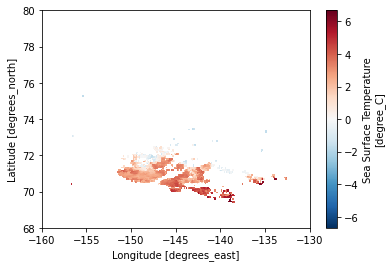

In [ ]:
print(granules_url)

None


In [ ]:
# load file(s)
# use sel and slice to get our region. MODIS SSTs have lat from + to -, so put the bigger lat value first in the slice
file_list =  [fs.open(file) for file in granules_url]
ds_modis = xr.open_mfdataset(file_list, preprocess=extract_time, engine='h5netcdf',concat_dim='time', combine='nested').sel(lon=slice(lonrange[0], lonrange[1]), lat=slice(latrange[1], latrange[0]))
ds_modis


<xarray.Dataset>
Dimensions:   (time: 1, lat: 288, lon: 720, rgb: 3, eightbitcolor: 256)
Coordinates:
  * time      (time) datetime64[ns] 2021-08-31
  * lat       (lat) float32 79.98 79.94 79.9 79.85 ... 68.15 68.1 68.06 68.02
  * lon       (lon) float32 -160.0 -159.9 -159.9 -159.9 ... -130.1 -130.1 -130.0
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    sst       (time, lat, lon) float32 dask.array<chunksize=(1, 288, 720), meta=np.ndarray>
    qual_sst  (time, lat, lon) float32 dask.array<chunksize=(1, 288, 720), meta=np.ndarray>
    palette   (time, rgb, eightbitcolor) uint8 dask.array<chunksize=(1, 3, 256), meta=np.ndarray>
Attributes: (12/61)
    product_name:                     AQUA_MODIS.20210831.L3m.DAY.SST.sst.4km.nc
    instrument:                       MODIS
    title:                            MODISA Level-3 Standard Mapped Image
    project:                          Ocean Biology Processing Group (NASA/GS...
    platform:                         Aqua
    temporal_range:                   day
    ...                               ...
    cdm_data_type:                    grid
    keywords:                         Earth Science > Oceans > Ocean Optics >...
    keywords_vocabulary:              NASA Global Change Master Directory (GC...
    data_bins:                        [6702869]
    data_minimum:                     [-1.795]
    data_maximum:                     [39.885]

### In situ data from UpTempO buoys

In [ ]:
# for now, just pick a single buoy & download it locally using wget (if new)
buoy_url = 'http://psc.apl.washington.edu/UpTempO/WebDATA/'
buoy_file = 'UpTempO_2019_02_SIZRS-20211117.dat'
buoy_url + buoy_file
!wget -N {buoy_url + buoy_file} -P downloads/

--2021-11-19 00:42:19--  http://psc.apl.washington.edu/UpTempO/WebDATA/UpTempO_2019_02_SIZRS-20211117.dat
Resolving psc.apl.washington.edu (psc.apl.washington.edu)... 74.114.88.224
Connecting to psc.apl.washington.edu (psc.apl.washington.edu)|74.114.88.224|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3339714 (3.2M)
Saving to: ‘downloads/UpTempO_2019_02_SIZRS-20211117.dat’

UpTempO_2019_02_SIZ 100%[===================>]   3.18M  19.4MB/s    in 0.2s    

2021-11-19 00:42:20 (19.4 MB/s) - ‘downloads/UpTempO_2019_02_SIZRS-20211117.dat’ saved [3339714/3339714]



In [ ]:
# for this file, we want to skip the first 35 lines (header). can later generalize this
filename = (f'downloads/{buoy_file}')
f = open(filename,'r')
# data = f.readlines()[35:]
data = f.readlines()[35:40] # start with a small # of rows
f.close()

# %DATA COLUMNS:
# % 0 = year
# % 1 = month
# % 2 = day
# % 3 = hour (GMT)
# % 4 = Latitude (N)
# % 5 = Longitude (E)
# % 6 = Ocean Pressure (dB) at Sensor #1(Nominal Depth = 20.0 m)
# % 7 = Ocean Pressure (dB) at Sensor #2(Nominal Depth = 40.0 m)
# % 8 = Ocean Pressure (dB) at Sensor #3(Nominal Depth = 60.0 m)
# % 9 = Temperature at nominal depth 0.0 (m)
# % 10 = Temperature at nominal depth 2.5 (m)
# % 11 = Temperature at nominal depth 5.0 (m)
# % 12 = Temperature at nominal depth 7.5 (m)
# % 13 = Temperature at nominal depth 10.0 (m)
# % 14 = Temperature at nominal depth 15.0 (m)
# % 15 = Temperature at nominal depth 20.0 (m)
# % 16 = Temperature at nominal depth 25.0 (m)
# % 17 = Temperature at nominal depth 30.0 (m)
# % 18 = Temperature at nominal depth 35.0 (m)
# % 19 = Temperature at nominal depth 40.0 (m)
# % 20 = Temperature at nominal depth 50.0 (m)
# % 21 = Temperature at nominal depth 60.0 (m)
# % 22 = Sea Level Pressure (mBar)
# % 23 = Battery Voltage (V)
# % 24 = Submergence Percent
# 2019 08 14 20.3500 72.013322 -149.817103 0.250 0.431 0.611 13.29 5.022276 3.85962 3.70969 3.468275 3.823188 3.630601 3.738509 3.441308 3.728554 3.573352 3.425621 3.545923 1011.2 12.8 0
# data[[:,1]]

df = pd.read_csv(filename, sep=' ', skiprows=35, names=["year", "month", "day", "hour", "lat", 
                                               "lon", "p20", "p40", "p60", "T0", "T2p5", 
                                               "T5", "T7p5", "T10", "T15", "T20", "T25", 
                                               "T30", "T35", "T40", "T50","T60", "SLP", "voltage", "sub_perc"],
                parse_dates= {"date" : ["year","month","day","hour"]})
df


,date,lat,lon,p20,p40,p60,T0,T2p5,T5,T7p5,...,T20,T25,T30,T35,T40,T50,T60,SLP,voltage,sub_perc
0,2019 08 14 20.3500,72.013322,-149.817103,0.250,0.431,0.611,13.29,5.022276,3.859620,3.709690,...,3.630601,3.738509,3.441308,3.728554,3.573352,3.425621,3.545923,1011.2,12.8,0
1,2019 08 14 20.5000,72.014633,-149.816719,17.595,34.396,52.101,7.13,3.107465,3.074085,3.066678,...,3.407026,1.840690,0.756569,0.396178,0.614274,0.625215,0.691400,1011.1,13.0,0
2,2019 08 14 20.6667,72.015750,-149.816042,17.954,36.381,55.351,3.25,3.036894,3.074085,3.046583,...,3.468003,1.434654,-0.118399,-0.335477,-0.301632,-0.075091,-0.004694,1011.3,13.0,0
3,2019 08 14 20.8333,72.016131,-149.815131,19.399,38.549,58.061,3.08,3.036894,3.064014,3.046583,...,3.132605,0.297593,-0.474545,-0.254179,-0.321989,-0.064941,-0.095493,1011.3,13.0,0
4,2019 08 14 21.0000,72.016525,-149.814336,20.121,39.632,58.421,3.07,3.077220,3.074085,3.046583,...,3.193590,0.297593,-0.494898,-0.244017,-0.403420,-0.176591,-0.105581,1011.4,13.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17433,2021 11 17 16.0000,86.210481,-161.858081,19.604,40.019,59.530,-10.30,-999.000000,-999.000000,-999.000000,...,-1.650102,-1.581105,-1.573715,-1.534700,-1.594660,-1.526706,-1.619002,1008.9,11.2,0
17434,2021 11 17 17.0000,86.211069,-161.844522,19.773,40.007,59.518,-10.23,-999.000000,-999.000000,-999.000000,...,-1.670477,-1.591262,-1.573715,-1.534700,-1.594660,-1.526706,-1.649273,1010.1,11.2,0
17435,2021 11 17 18.0000,86.211781,-161.829144,19.761,39.995,59.687,-10.03,-999.000000,-999.000000,-999.000000,...,-1.629727,-1.581105,-1.573715,-1.534700,-1.584476,-1.526706,-1.649273,1011.3,11.2,0
17436,2021 11 17 19.0000,86.212508,-161.814686,19.752,39.986,59.497,-10.01,-999.000000,-999.000000,-999.000000,...,-1.660289,-1.591262,-1.573715,-1.555027,-1.615029,-1.526706,-1.649273,1012.2,11.2,0


In [ ]:
# not quite right but close!
# df['dates'] = pd.to_datetime({df['year'],df['month'], df['day']}, format='%Y%m%d')



TypeError: unhashable type: 'Series'

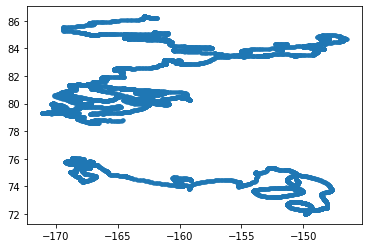

In [ ]:
plt.plot(df['lon'],df['lat'],'.')

In [ ]:
# identify data from our date range


In [ ]:
# plt.plot(data_vars[lon])
# plt.show()
# attrs['sss_smap']
# smap_l2 = xr.Dataset(data_vars)
# data_vars?

# data_vars (dict-like, optional) – A mapping from variable names to DataArray objects,
# Variable objects or to tuples of the form (dims, data[, attrs]) which can be used as arguments 
# to create a new Variable. Each dimension must have the same length in all variables in which it appears.

# The following notations are accepted:

#     mapping {var name: DataArray}

#     mapping {var name: Variable}

#     mapping {var name: (dimension name, array-like)}

#     mapping {var name: (tuple of dimension names, array-like)}

#     mapping {dimension name: array-like} (it will be automatically moved to coords, see below)

# Each dimension must have the same length in all variables in which it appears.




Type:        dict
String form:
{'lat': (['segment'], array([-89.875, -89.625, -89.375, -89.125, -88.875, -88.625, -88.375,
           <...> ([1.], dtype=float32), 'add_offset': array([0.], dtype=float32), 'coordinates': 'lon lat time'})}
Length:      4
Docstring:  
dict() -> new empty dictionary
dict(mapping) -> new dictionary initialized from a mapping object's
    (key, value) pairs
dict(iterable) -> new dictionary initialized as if via:
    d = {}
    for k, v in iterable:
        d[k] = v
dict(**kwargs) -> new dictionary initialized with the name=value pairs
    in the keyword argument list.  For example:  dict(one=1, two=2)
